![image.png](attachment:ad7ccc24-be80-4202-8d58-3ec6a78b4c23.png)



#  E-Waste Image Classification Using EfficientNetV2B0 (Transfer Learning)



##  Problem Statement and Description

E-waste (electronic waste) is rapidly becoming a serious environmental and health issue around the world. Proper sorting and categorization of e-waste is essential for efficient recycling and disposal, but manual classification is error-prone and labor-intensive.

This project aims to build an automated e-waste classification system using artificial intelligence and machine learning. By training a deep learning model on images of different types of e-waste, we can identify and categorize them accurately.

###  Goal:
Use image classification with EfficientNetV2B0 to classify e-waste into 10 distinct categories to support better sorting and recycling automation.

---
</div>




##  Dataset Overview

###  Dataset Name: E-Waste Image Dataset  
###  Source:  https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset

Each directory contains 10 subfolders, each representing one class of e-waste:

- PCB (Printed Circuit Board)
- Player
- Battery
- Microwave
- Mobile
- Mouse
- Printer
- Television
- Washing Machine
- Keyboard

</div>

![image.png](attachment:5fe4e2cd-166c-4a06-93db-01d11bd9d78a.png)




##  What is Transfer Learning?

Transfer Learning: Transfer Learning is a machine learning technique where a pre-trained model developed for a specific task is reused as the starting point for a model on a different but related task. It also allows us to build accurate models in a time-saving way by starting from patterns learned when solving a different problem. This approach is beneficial when there is limited data for the new task, as the pre-trained model already has learned features that can be adapted. Transfer learning can significantly improve models' performance and efficiency in domains like computer vision and natural language processing.

###  Benefits
-  **Reduces training time** — you don't start from scratch.
-  **Leverages learned features** from large datasets (like ImageNet).
-  **Improves performance**, especially with limited data.

---

##  How Does It Work?

1.  Load a pretrained model (e.g., ResNet, EfficientNet).
2.  **Freeze** the pretrained layers (optional).
3.  Add new layers for your custom task.
4.  Train on your new dataset (can also fine-tune).

---

#  EfficientNetV2B0: Transfer Learning Backbone

##  Overview

EfficientNetV2 is an optimized family of models introduced by Google for efficient training and inference.

###  Key Features:
-  Fused MBConv blocks — improve training speed and GPU efficiency.
-  Progressive learning — gradually increases input size during training.
-  Better accuracy with fewer parameters and FLOPs.

---

##  Why Use EfficientNetV2B0?
 -  Lightweight - Small model size, ideal for mobile & edge devices
 -  Fast - Quick training and inference           
 -  Pretrained on ImageNet - Excellent feature extraction baseline             
 -  High Accuracy - Competitively performs even in low-resource setups



In [1]:
# Install TensorFlow package
!pip install tensorflow

###  Core Libraries
- `tensorflow`: For deep learning model building and training.
- `numpy`: For numerical operations and array manipulation.
- `matplotlib.pyplot`: For plotting training curves and results.


In [2]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


###  Format: Folder-based image classification dataset  
- `Train/`: Images used for training the model  
- `Test/`: Images used for model evaluation  
- `Validation/`: Images used to fine-tune and validate the model  


In [3]:
testpath= r'C:\Users\Edunet Foundation\Downloads\project\E waste data\modified-dataset\test'
trainpath= r'C:\Users\Edunet Foundation\Downloads\project\E waste data\modified-dataset\train'
validpath = r'C:\Users\Edunet Foundation\Downloads\project\E waste data\modified-dataset\val'

## 1.  Explore and Understand the Data
- Load image dataset using tools like `image_dataset_from_directory`.
- Visualize sample images from each class.
- Check the number of images per class to ensure balance.
- Understand image dimensions, color channels, and class labels.



### Load image dataset using tools like `image_dataset_from_directory`.
### Split data into training, validation, and testing sets.

`tf.keras.utils.image_dataset_from_directory(...)`  
Used to load images from a directory where each subfolder represents a class.

---

**path**  
Root directory path containing one subdirectory per class.

**shuffle=True**  
Randomly shuffles the image data. Useful during training to prevent the model from learning the order of the data.

**image_size=(128, 128)**  
Resizes all loaded images to this target size (width, height).  
This must match the input size expected by the model.

**batch_size=32**  
Number of images per batch during training.  
This affects memory usage and the frequency of model updates.

**validation_split=False**  
If set to a float (e.g., `0.2`), splits a portion of the data for validation.  
If `False`, no split is applied.


In [4]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

NotFoundError: Could not find directory C:\Users\Edunet Foundation\Downloads\project\E waste data\modified-dataset\train

In [ ]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

In [ ]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

In [ ]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

### Visualize sample images from each class.

In [ ]:

# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")


- ## Check the number of images per class to ensure balance
- ## Understand image properties like Image dimensions, Class labels


In [ ]:
def plot_class_distribution(dataset, title="Class Distribution"):
    """
    Plots the number of items per class in a given dataset.

    Args:
        dataset: A tf.data.Dataset object created using image_dataset_from_directory
        title: Title for the plot (e.g., 'Train Data Distribution')
    """

    class_counts = {}  # Dictionary to hold the count of each class

    # Iterate through the batches in the dataset
    for images, labels in dataset:
        # Convert labels tensor to numpy array and loop through each label
        for label in labels.numpy():
            class_name = dataset.class_names[label]  # Get class name using label index
            # Increment the count for this class
            class_counts[class_name] = class_counts.get(class_name, 0) + 1


In [ ]:

    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class


In [ ]:

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot


In [ ]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalid, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")


## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet).

In [ ]:

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])


## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetV2B0`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training.

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`,
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.

### Model Architecture and Layer Utilities

- **Sequential**: A simple way to build models by stacking layers one after the other in a linear fashion.

- **RandomFlip**: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

- **RandomRotation**: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

- **RandomZoom**: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

- **Dropout**: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

- **GlobalAveragePooling2D**: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

- **Dense**: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

- **Input**: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

- **EfficientNetV2B0**: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.





In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

###  Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving.

In [ ]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)


### Train the model using `.fit()` with appropriate `epochs`, `batch_size`, and callbacks like `EarlyStopping`.

In [ ]:
# Set the number of epochs to train the model
epochs = 15

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    batch_size=100,                 # Number of samples per gradient update
    callbacks=[early]               # List of callbacks to apply during training (e.g., early stopping)
)


### Model Architechure of EfficientNETV2

In [ ]:
model.summary() # Print the architecture summary of the  model

In [ ]:
base_model.summary() # Print the architecture summary of the base model

# Model Performance Visualization: Accuracy & Loss Trends

In [ ]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

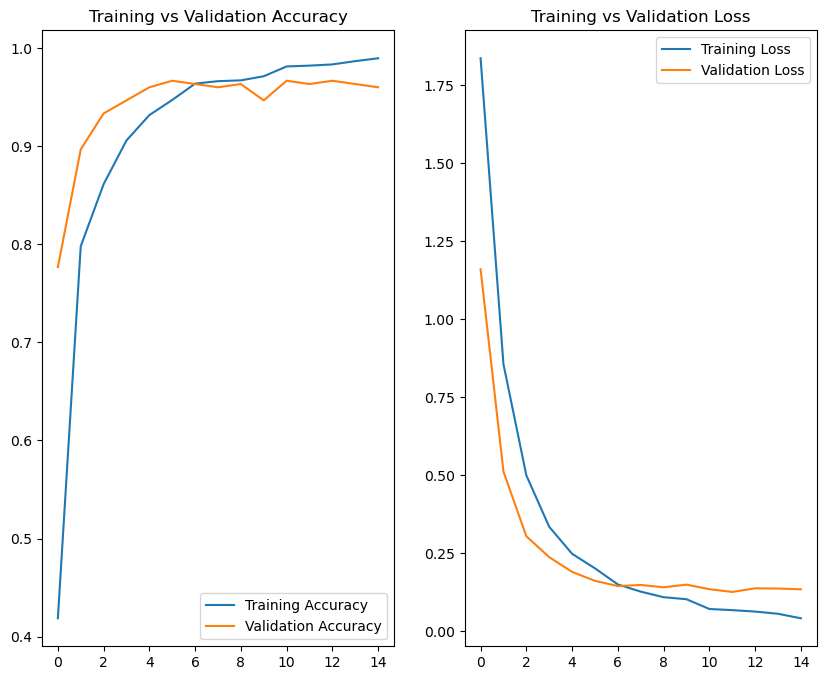

In [ ]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots


## 6.  Model Evaluation
- Plot training and validation accuracy/loss curves.
- Evaluate model performance on validation or test set.
- Use metrics like:
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1-score)
  - `confusion_matrix`, `classification_report`: To evaluate the model's classification performance.




In [ ]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 541ms/step - Accuracy: 0.9522 - loss: 0.1211
Test accuracy is0.9600, Test loss is 0.1073


In [ ]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))


10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step 
[[27  0  0  0  0  2  1  0  0  0]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 28  0  0  0  1  1  0  0]
 [ 0  0  0 30  0  0  0  0  0  0]
 [ 0  0  0  0 29  0  0  1  0  0]
 [ 0  0  0  0  0 29  1  0  0  0]
 [ 1  0  0  0  0  0 29  0  0  0]
 [ 0  0  0  0  0  0  1 29  0  0]
 [ 0  0  3  0  0  0  0  0 27  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.96      0.90      0.93        30
           1       1.00      1.00      1.00        30
           2       0.90      0.93      0.92        30
           3       1.00      1.00      1.00        30
           4       1.00      0.97      0.98        30
           5       0.94      0.97      0.95        30
           6       0.88      0.97      0.92        30
           7       0.94      0.97      0.95        30
           8       1.00      0.90      0.95        30
           9       1.00      1.00      1.00        30

    accuracy                     

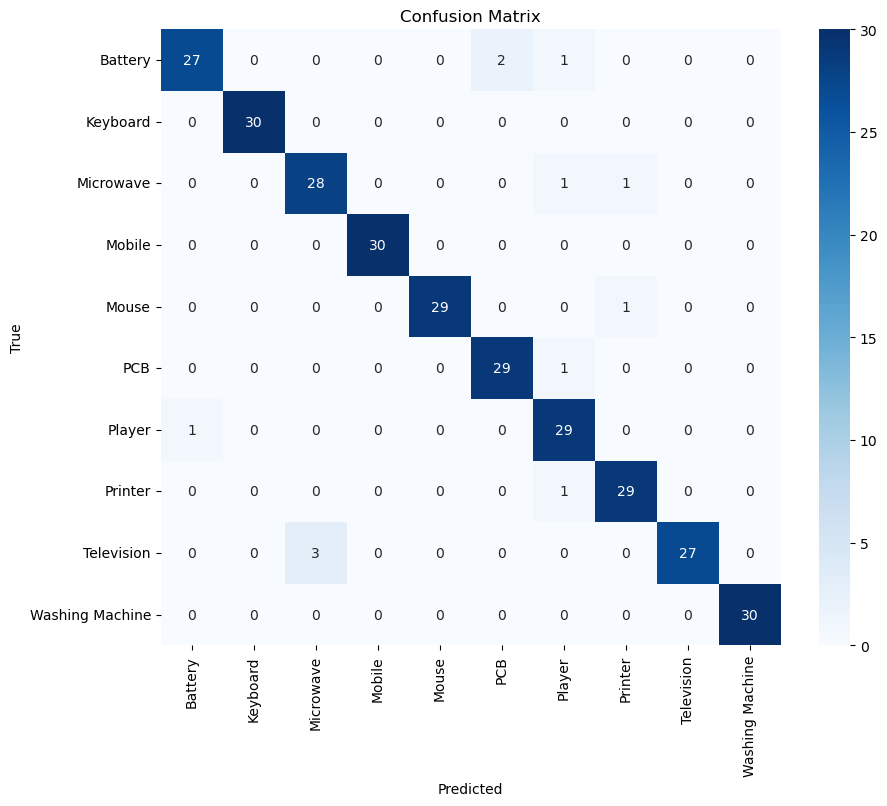

In [ ]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


## 7.  Final Testing and Save the Model
- Evaluate the final model on the unseen **test dataset**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


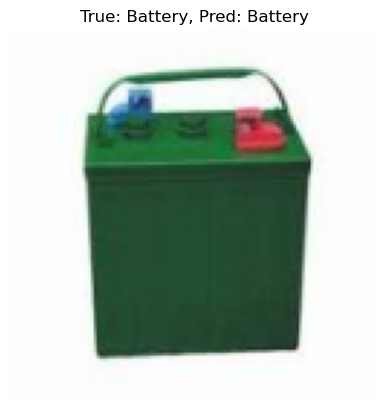

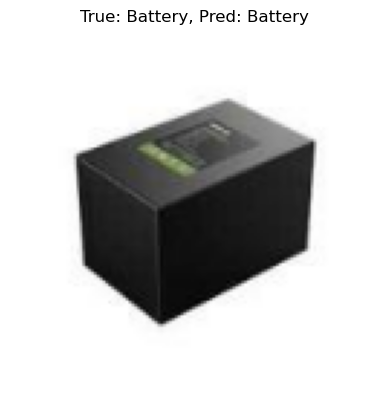

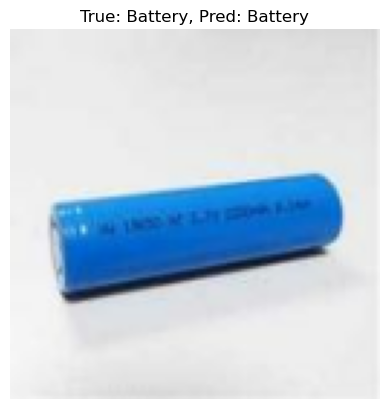

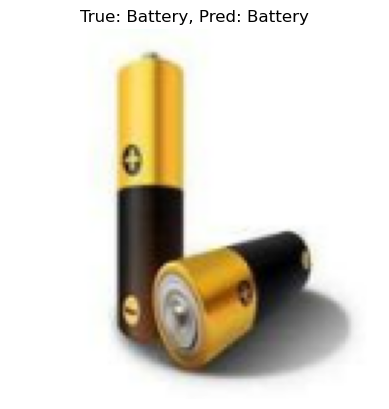

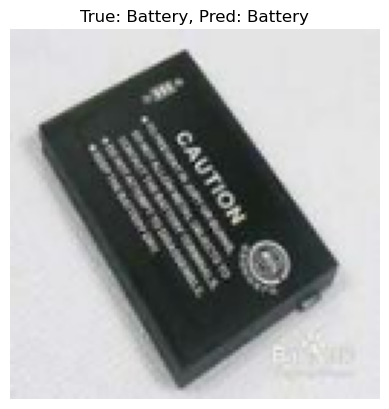

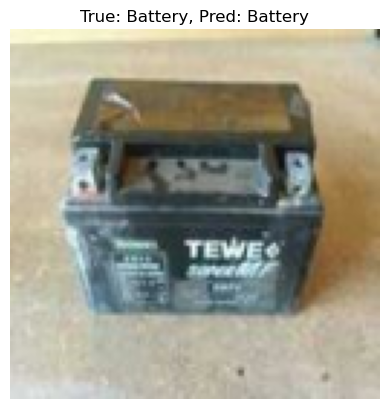

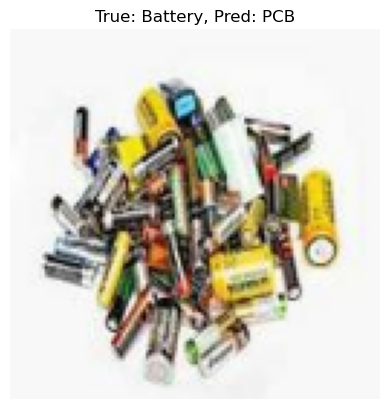

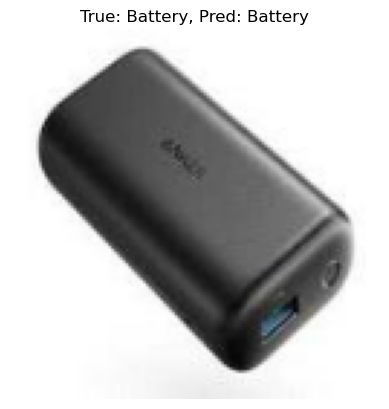

In [ ]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image



**Save the trained model using `model.save()` or `save_model()` for future inference.**

In [ ]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [ ]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')


## 8.  Model Deployment (Optional)
- Create a web interface using **Gradio**.
- Load the saved model and preprocess input images before prediction.

In [ ]:
!pip install gradio

### 🌐 Gradio Interface and Preprocessing
- `gr`: To build a web interface for the model.
- `PIL.Image`: For handling image input in Gradio.
- `preprocess_input`: Preprocessing method for EfficientNet.
- `load_model`: For loading a saved model for inference.


In [ ]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"



In [ ]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
